In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import re
import os
from scripts.ari import ari_to_features
import argparse
import logging

from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
from ast import literal_eval
logger = logging.getLogger(__name__)

In [10]:
def get_artist(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None


def show_album_tracks(album):
    tracks = []
    results = sp.album_tracks(album['id'])
    tracks.extend(results['items'])
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    for i, track in enumerate(tracks):
        logger.info('%s. %s', i+1, track['name'])
    
    return tracks
        
    


def show_artist_albums(artist):
    albums = []
    trks = []
    results = sp.artist_albums(artist['id'], album_type='album')
    albums.extend(results['items'])
    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])
    logger.info('Total albums: %s', len(albums))
    unique = set()  # skip duplicate albums
    for album in albums:
        name = album['name'].lower()
        if name not in unique:
            logger.info('ALBUM: %s', name)
            unique.add(name)
            trks.extend(show_album_tracks(album))
    
    return trks


def show_artist(artist):
    logger.info('====%s====', artist['name'])
    logger.info('Popularity: %s', artist['popularity'])
    if len(artist['genres']) > 0:
        logger.info('Genres: %s', ','.join(artist['genres']))
        

def get_all_tracks(artist):
    
    art_d = get_artist(artist)
    tracks_df = pd.DataFrame(show_artist_albums(art_d))
    return tracks_df

In [55]:
df = pd.read_csv('../data/song_features.csv')
df['artist_name'] = df['artists'].apply(lambda x: literal_eval(x)[0]['name'].lower())
df['genre_label'] = df['genres'].apply(lambda x:x.split(' ')[0])
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
artists,"[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1DGpHnPOpMYY780hcQHmPB'}, 'href': 'https://api.spotify.com/v1/artists/1DGpHnPOpMYY780hcQHmPB', 'id': '1DGpHnPOpMYY780hcQHmPB', 'name': 'Hiroshi Yoshimura', 'type': 'artist', 'uri': 'spotify:artist:1DGpHnPOpMYY780hcQHmPB'}]","[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1DGpHnPOpMYY780hcQHmPB'}, 'href': 'https://api.spotify.com/v1/artists/1DGpHnPOpMYY780hcQHmPB', 'id': '1DGpHnPOpMYY780hcQHmPB', 'name': 'Hiroshi Yoshimura', 'type': 'artist', 'uri': 'spotify:artist:1DGpHnPOpMYY780hcQHmPB'}]","[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1DGpHnPOpMYY780hcQHmPB'}, 'href': 'https://api.spotify.com/v1/artists/1DGpHnPOpMYY780hcQHmPB', 'id': '1DGpHnPOpMYY780hcQHmPB', 'name': 'Hiroshi Yoshimura', 'type': 'artist', 'uri': 'spotify:artist:1DGpHnPOpMYY780hcQHmPB'}]","[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1DGpHnPOpMYY780hcQHmPB'}, 'href': 'https://api.spotify.com/v1/artists/1DGpHnPOpMYY780hcQHmPB', 'id': '1DGpHnPOpMYY780hcQHmPB', 'name': 'Hiroshi Yoshimura', 'type': 'artist', 'uri': 'spotify:artist:1DGpHnPOpMYY780hcQHmPB'}]","[{'external_urls': {'spotify': 'https://open.spotify.com/artist/1DGpHnPOpMYY780hcQHmPB'}, 'href': 'https://api.spotify.com/v1/artists/1DGpHnPOpMYY780hcQHmPB', 'id': '1DGpHnPOpMYY780hcQHmPB', 'name': 'Hiroshi Yoshimura', 'type': 'artist', 'uri': 'spotify:artist:1DGpHnPOpMYY780hcQHmPB'}]"
available_markets,"['AT', 'CH', 'DE', 'DK', 'FI', 'NO', 'SE']","['AT', 'CH', 'DE', 'DK', 'FI', 'NO', 'SE']","['AT', 'CH', 'DE', 'DK', 'FI', 'NO', 'SE']","['AT', 'CH', 'DE', 'DK', 'FI', 'NO', 'SE']","['AT', 'CH', 'DE', 'DK', 'FI', 'NO', 'SE']"
disc_number,1,1,1,1,1
duration_ms_x,362160,273866,332133,410333,321666
explicit,False,False,False,False,False
external_urls,{'spotify': 'https://open.spotify.com/track/2LiqK1oqzrqnxH6zaDLqAW'},{'spotify': 'https://open.spotify.com/track/17kSn9eA0hG6HTAFvp76BS'},{'spotify': 'https://open.spotify.com/track/0CR4jQApsVlVUFF7dYhkNC'},{'spotify': 'https://open.spotify.com/track/2guvKppGQ7Fsgi4ZAGILc6'},{'spotify': 'https://open.spotify.com/track/0HEzGwip1s4seBM0s4fQhW'}
href,https://api.spotify.com/v1/tracks/2LiqK1oqzrqnxH6zaDLqAW,https://api.spotify.com/v1/tracks/17kSn9eA0hG6HTAFvp76BS,https://api.spotify.com/v1/tracks/0CR4jQApsVlVUFF7dYhkNC,https://api.spotify.com/v1/tracks/2guvKppGQ7Fsgi4ZAGILc6,https://api.spotify.com/v1/tracks/0HEzGwip1s4seBM0s4fQhW
id,2LiqK1oqzrqnxH6zaDLqAW,17kSn9eA0hG6HTAFvp76BS,0CR4jQApsVlVUFF7dYhkNC,2guvKppGQ7Fsgi4ZAGILc6,0HEzGwip1s4seBM0s4fQhW
is_local,False,False,False,False,False


In [56]:
filter_columns = ['duration_ms_x', 'explicit', 'is_local', 'track_number',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo','time_signature']

y_columns = ['artist_pop', 'genre_label', 'track_pop']

In [91]:

df.artist_name.unique()

array(['hiroshi yoshimura', 'inoyamaland', 'endel', 'green-house',
       'brian eno', 'robert fripp', 'toto', 'passengers', 'roger eno',
       'tom rogerson', 'eno • hyde', 'harmonia', 'david byrne',
       'jah wobble', 'james', 'harold budd', 'laraaji', 'jon hassell',
       'cluster', 'haruomi hosono', 'hosono haruomi', 'ノンスタンダード合唱団',
       '中原香織', 'masataka matsutoya', 'takahiko ishikawa',
       'harry hosono & the world shyness', 'shigeru suzuki',
       'tatsuro yamashita', 'emily a. sprague', 'lightbath', 'vangelis',
       'irina valentinova', 'jon & vangelis', 'kritikes madares',
       'psarantonis', 'loudovicos ton anogion', 'irene papas',
       'vassilis saleas', 'jon anderson', 'mariangela celeste'],
      dtype=object)

In [58]:
import pandas as pd
from autogluon.tabular import TabularDataset, TabularPredictor

def train_autogluon_model(dataframe: pd.DataFrame, target_variable: str, time_limit: int = 300):
    """
    Train a machine learning model using AutoGluon given a DataFrame and target variable.
    
    Parameters:
    dataframe (pd.DataFrame): The input DataFrame containing the features and target variable.
    target_variable (str): The name of the column in the DataFrame that represents the target variable.
    time_limit (int): The time limit in seconds for the model training process (default: 60 seconds).
    
    Returns:
    TabularPredictor: The trained AutoGluon predictor.
    """
    # Create a TabularDataset from the input DataFrame
    train_data = TabularDataset(dataframe)

    # Create a TabularPredictor instance
    if target_variable in ('artist_pop','track_pop'):
        predictor = TabularPredictor(label=target_variable,problem_type='regression')
    else:
        predictor = TabularPredictor(label=target_variable)

    # Train the model
    predictor.fit(train_data, time_limit=time_limit)

    return predictor


In [59]:
predictor_obj = {}
df_fs = {}
for y in y_columns:
    f_col = filter_columns + [y]
    df_fs[y] = df[f_col]
    predictor_obj[y] = train_autogluon_model(dataframe=df_fs[y],target_variable=y)

No path specified. Models will be saved in: "AutogluonModels/ag-20230325_195544/"
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "AutogluonModels/ag-20230325_195544/"
AutoGluon Version:  0.7.0
Python Version:     3.9.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.3.0: Mon Jan 30 20:38:37 PST 2023; root:xnu-8792.81.3~2/RELEASE_ARM64_T6000
Train Data Rows:    1754
Train Data Columns: 16
Label Column: artist_pop
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5417.9 MB
	Train Data (Original)  Memory Usage: 0.2 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
			Note: Converting 1 features to boolean dtype as they only contain

		('float', [])     : 9 | ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', ...]
		('int', [])       : 4 | ['duration_ms_x', 'track_number', 'key', 'time_signature']
		('int', ['bool']) : 1 | ['mode']
	0.0s = Fit runtime
	14 features in original data used to generate 14 features in processed data.
	Train Data (Processed) Memory Usage: 0.18 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.03s ...
AutoGluon will gauge predictive performance using evaluation metric: 'accuracy'
	To change this, specify the eval_metric parameter of Predictor()
Automatically generating train/validation split with holdout_frac=0.2, Train Rows: 1388, Val Rows: 347
Fitting 13 L1 models ...
Fitting model: KNeighborsUnif ... Training model for up to 299.97s of the 299.97s of remaining time.
	0.3573	 = Validation score   (accuracy)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: KNeighborsDist ... Training model for up to 299.96s of th

	-11.0734	 = Validation score   (-root_mean_squared_error)
	0.93s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: NeuralNetTorch ... Training model for up to 294.51s of the 294.51s of remaining time.
	-11.05	 = Validation score   (-root_mean_squared_error)
	1.18s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 293.32s of the 293.32s of remaining time.
	-11.2427	 = Validation score   (-root_mean_squared_error)
	4.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 299.97s of the 289.15s of remaining time.
	-10.7475	 = Validation score   (-root_mean_squared_error)
	0.1s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 10.96s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20230325_195729/")


In [67]:
import matplotlib.pyplot as plt
#from autogluon.core.utils import plot_importance

def visualize_feature_importance(predictor):
    """
    Extract feature importance information from the predictor object and create a bar plot visualization.

    Parameters:
    predictor (TabularPredictor): The trained AutoGluon predictor.
    """
    # Get feature importance information
    
    feature_importance = predictor.feature_importance(df)
    print(feature_importance)

    # Create a bar plot for feature importance
#     plt.figure(figsize=(10, 6))
#     plt.barh(feature_importance.index, feature_importance.values, color='blue')
#     plt.xlabel('Feature Importance')
#     plt.title('Feature Importance')
#     plt.gca().invert_yaxis()
#     plt.show()


In [89]:
df.genre_label.unique()

array(['ambient', 'fourth_world', 'unknown', 'album_rock', 'ambient_pop',
       'electronic_rock', 'art_rock', 'art_pop', 'experimental_dub',
       'britpop', 'classic_j-rock', 'japanese_choir', 'classic_city_pop',
       'techno_kayo', 'cyberpunk', 'kritika', 'greek_clarinet'],
      dtype=object)

In [68]:
visualize_feature_importance(predictor_obj['artist_pop'])

These features in provided data are not utilized by the predictor and will be ignored: ['Unnamed: 0', 'artists', 'available_markets', 'disc_number', 'explicit', 'external_urls', 'href', 'id', 'is_local', 'name', 'preview_url', 'type_x', 'uri_x', 'type_y', 'uri_y', 'track_href', 'analysis_url', 'duration_ms_y', 'genres', 'track_pop', 'artist_name', 'genre_label']
Computing feature importance via permutation shuffling for 14 features using 1754 rows with 5 shuffle sets...
	7.18s	= Expected runtime (1.44s per shuffle set)
	1.88s	= Actual runtime (Completed 5 of 5 shuffle sets)


                  importance    stddev       p_value  n  p99_high   p99_low
loudness            4.335557  0.141983  1.378234e-07  5  4.627901  4.043212
acousticness        2.929440  0.132525  5.012511e-07  5  3.202312  2.656569
danceability        1.892544  0.047101  4.600192e-08  5  1.989526  1.795561
valence             1.256905  0.078797  1.843891e-06  5  1.419149  1.094661
energy              1.180026  0.026669  3.128578e-08  5  1.234938  1.125114
instrumentalness    1.050603  0.030435  8.441477e-08  5  1.113268  0.987937
duration_ms_x       0.960295  0.041146  4.034540e-07  5  1.045014  0.875575
speechiness         0.930208  0.065114  2.862372e-06  5  1.064278  0.796137
key                 0.898291  0.035895  3.053082e-07  5  0.972199  0.824382
tempo               0.690159  0.042967  1.793431e-06  5  0.778628  0.601689
liveness            0.671039  0.044378  2.282159e-06  5  0.762415  0.579663
track_number        0.513682  0.033956  2.278058e-06  5  0.583598  0.443765
time_signatu

In [69]:
visualize_feature_importance(predictor_obj['genre_label'])

These features in provided data are not utilized by the predictor and will be ignored: ['Unnamed: 0', 'artists', 'available_markets', 'disc_number', 'explicit', 'external_urls', 'href', 'id', 'is_local', 'name', 'preview_url', 'type_x', 'uri_x', 'type_y', 'uri_y', 'track_href', 'analysis_url', 'duration_ms_y', 'artist_pop', 'genres', 'track_pop', 'artist_name']
Computing feature importance via permutation shuffling for 14 features using 1735 rows with 5 shuffle sets...
	8.68s	= Expected runtime (1.74s per shuffle set)
	4.86s	= Actual runtime (Completed 5 of 5 shuffle sets)


                  importance    stddev       p_value  n  p99_high   p99_low
loudness            0.173948  0.005382  1.098457e-07  5  0.185030  0.162866
danceability        0.102824  0.007043  2.624279e-06  5  0.117325  0.088323
acousticness        0.096138  0.004636  6.469344e-07  5  0.105684  0.086593
speechiness         0.071700  0.007136  1.162170e-05  5  0.086394  0.057007
duration_ms_x       0.061441  0.004067  2.291277e-06  5  0.069816  0.053066
instrumentalness    0.057061  0.005543  1.055549e-05  5  0.068474  0.045647
liveness            0.028588  0.004833  9.436196e-05  5  0.038538  0.018638
key                 0.024323  0.001795  3.534495e-06  5  0.028019  0.020627
energy              0.024092  0.002978  2.746005e-05  5  0.030224  0.017960
tempo               0.024092  0.002390  1.147768e-05  5  0.029014  0.019170
valence             0.022478  0.001912  6.216300e-06  5  0.026414  0.018542
track_number        0.015677  0.002425  6.654634e-05  5  0.020670  0.010684
mode        

In [70]:
visualize_feature_importance(predictor_obj['track_pop'])

These features in provided data are not utilized by the predictor and will be ignored: ['Unnamed: 0', 'artists', 'available_markets', 'disc_number', 'explicit', 'external_urls', 'href', 'id', 'is_local', 'name', 'preview_url', 'type_x', 'uri_x', 'type_y', 'uri_y', 'track_href', 'analysis_url', 'duration_ms_y', 'artist_pop', 'genres', 'artist_name', 'genre_label']
Computing feature importance via permutation shuffling for 14 features using 1754 rows with 5 shuffle sets...
	7.64s	= Expected runtime (1.53s per shuffle set)
	1.66s	= Actual runtime (Completed 5 of 5 shuffle sets)


                  importance    stddev       p_value  n  p99_high   p99_low
track_number        1.252765  0.091979  3.462136e-06  5  1.442151  1.063378
acousticness        1.158135  0.065517  1.223784e-06  5  1.293035  1.023235
duration_ms_x       0.993720  0.027731  7.269896e-08  5  1.050818  0.936621
energy              0.968992  0.045237  5.683713e-07  5  1.062137  0.875847
danceability        0.958281  0.054470  1.247268e-06  5  1.070435  0.846127
valence             0.830190  0.030873  2.290746e-07  5  0.893758  0.766623
instrumentalness    0.828696  0.033934  3.366298e-07  5  0.898566  0.758826
tempo               0.734032  0.024150  1.403933e-07  5  0.783757  0.684308
key                 0.638519  0.017767  7.185979e-08  5  0.675101  0.601936
speechiness         0.590851  0.045519  4.193799e-06  5  0.684575  0.497127
loudness            0.589843  0.045611  4.256560e-06  5  0.683756  0.495929
liveness            0.508478  0.010728  2.376075e-08  5  0.530567  0.486390
time_signatu

<Axes: xlabel='duration_ms_x', ylabel='tempo'>

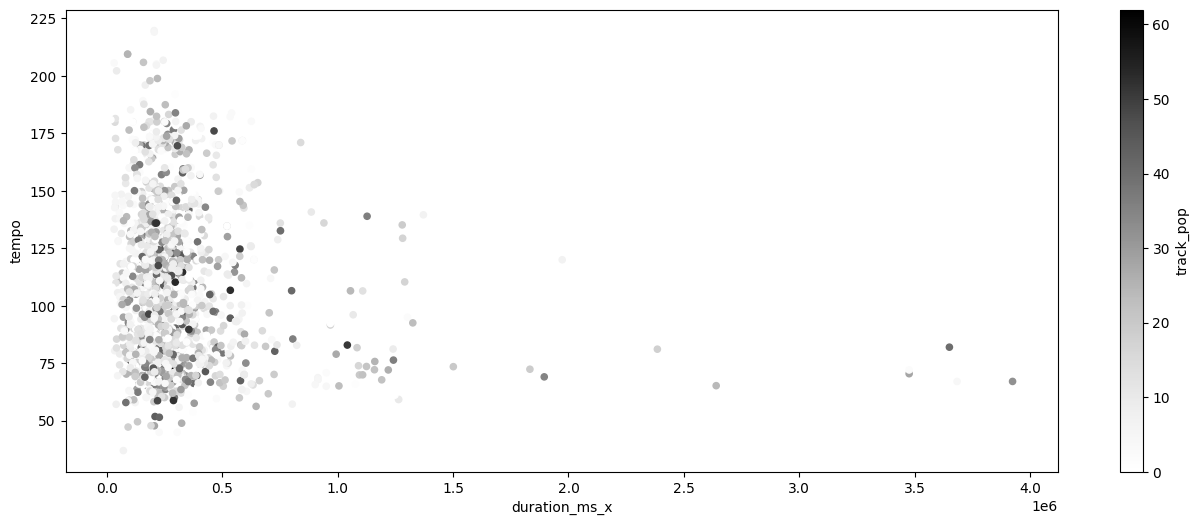

In [83]:
df.plot(x='duration_ms_x',y='tempo',c='track_pop',kind='scatter',figsize=(16,6))

<Axes: xlabel='duration_ms_x', ylabel='acousticness'>

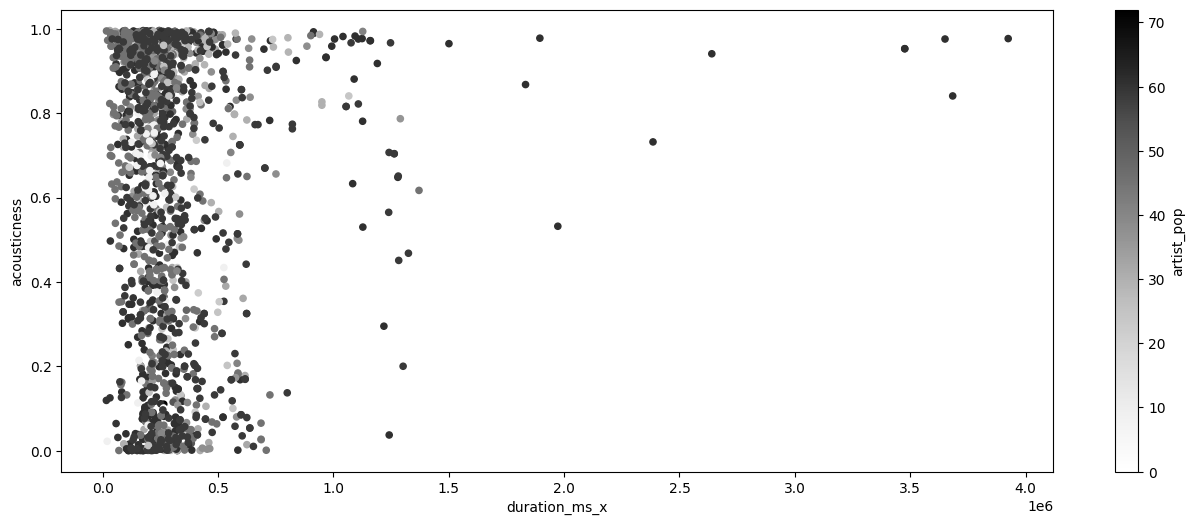

In [99]:
df.plot(x='duration_ms_x',y='acousticness',c='artist_pop',kind='scatter',figsize=(16,6))

<Axes: xlabel='duration_ms_x', ylabel='acousticness'>

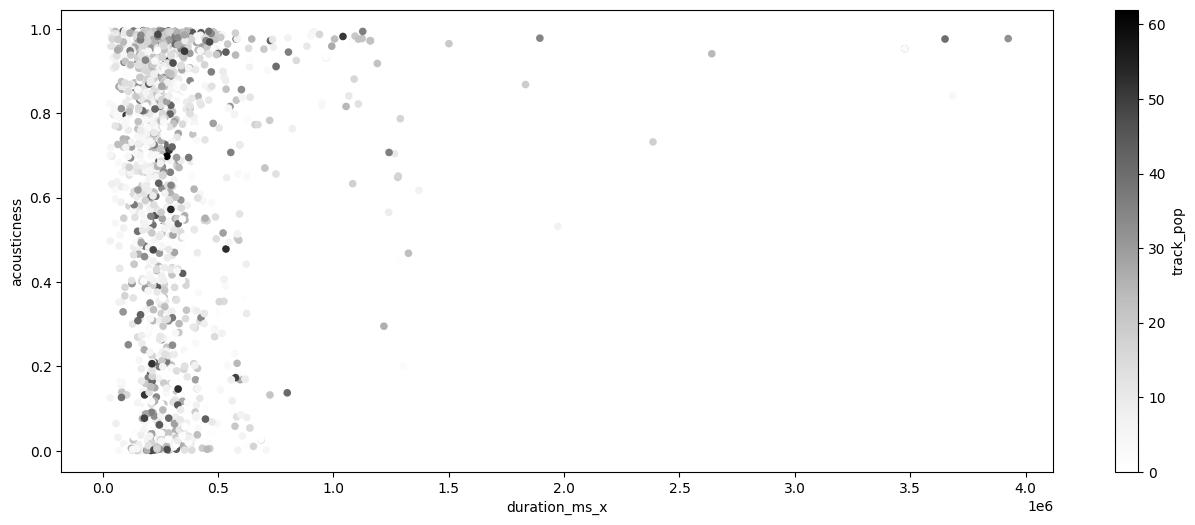

In [103]:
df.plot(x='duration_ms_x',y='acousticness',c='track_pop',kind='scatter',figsize=(16,6))